In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pymc as pm
import arviz as az
import pytensor.tensor as at
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

os.chdir(os.getcwd())

In [2]:
# data from Gossner et al (2022)
data = pd.read_csv("dengue_travel_europe.csv")

infected = data["infected travellers"].values.astype("int") 
total = data["total travellers"].values.astype("int")
N = len(data)

travellers = np.array([infected, total-infected])

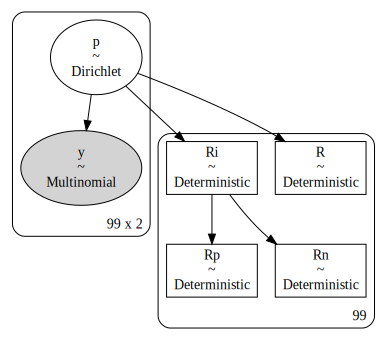

In [3]:
with pm.Model() as mod:
    p = pm.Dirichlet("p", a=np.ones([99,2]))
    y = pm.Multinomial("y", n=total, p=p, observed=travellers.T)
    I = p.T[0]
    T = p.T[0] + p.T[1]
    R = pm.Deterministic("R", 100000*I/T) #travellers rate of infection per 100000 travellers
    Ri = pm.Deterministic("Ri", (p.T[0]/p.T[1])*total) #raw risk (see Lee et al, 2021), i.e. ratio of infected and healthy travellers by total travellers 
    Rn = pm.Deterministic("Rn", Ri/Ri.max()) #normalised risk
    Rp = pm.Deterministic("Rp", Ri/Ri.sum()) #proportion of risk per country


dag = pm.model_to_graphviz(mod)
dag.render("model_dag", format="png")
dag

In [4]:
with mod:
    idata = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Chain <xarray.DataArray 'chain' ()>
array(0)
Coordinates:
    chain    int32 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(1)
Coordinates:
    chain    int32 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(2)
Coordinates:
    chain    int32 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain <xarray.DataArray 'chain' ()>
array(3)
Coordinates:
    chain    int32 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [5]:
pos = idata.stack(sample = ['chain', 'draw']).posterior

az.plot_energy(idata)
plt.savefig("energy.png", dpi=300)
plt.close()

summ = az.summary(idata, hdi_prob=0.95)
summ['country'] = list(np.tile(data.country.values, 6))
summ.to_csv("summary.csv")
summ

C:\Users\dts-cf924702\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
p[0, 0]  0.000  0.000     0.000      0.000        0.0      0.0    5781.0   
p[0, 1]  1.000  0.000     1.000      1.000        0.0      0.0    5781.0   
p[1, 0]  0.000  0.000     0.000      0.000        0.0      0.0    5064.0   
p[1, 1]  1.000  0.000     1.000      1.000        0.0      0.0    5064.0   
p[2, 0]  0.000  0.000     0.000      0.000        0.0      0.0    6097.0   
...        ...    ...       ...        ...        ...      ...       ...   
Rp[94]   0.000  0.000     0.000      0.001        0.0      0.0    5522.0   
Rp[95]   0.005  0.001     0.004      0.006        0.0      0.0    7011.0   
Rp[96]   0.003  0.001     0.002      0.004        0.0      0.0    5129.0   
Rp[97]   0.001  0.000     0.001      0.002        0.0      0.0    6254.0   
Rp[98]   0.001  0.000     0.000      0.001        0.0      0.0    6490.0   

         ess_tail  r_hat                country  
p[0, 0]    2945.0    1.0               Thailand  
p[0, 1]    2945.0    1.0              Indonesia  
p[1, 0]    2695.0    1.0            Philippines  
p[1, 1]    2695.0    1.0                Vietnam  
p[2, 0]    3248.0    1.0               Cambodia  
...           ...    ...                    ...  
Rp[94]     2635.0    1.0                  Samoa  
Rp[95]     2822.0    1.0              Melanesia  
Rp[96]     3034.0    1.0  New Caledonia, France  
Rp[97]     3153.0    1.0                   Fiji  
Rp[98]     2779.0    1.0       Papua New Guinea  

[594 rows x 10 columns]

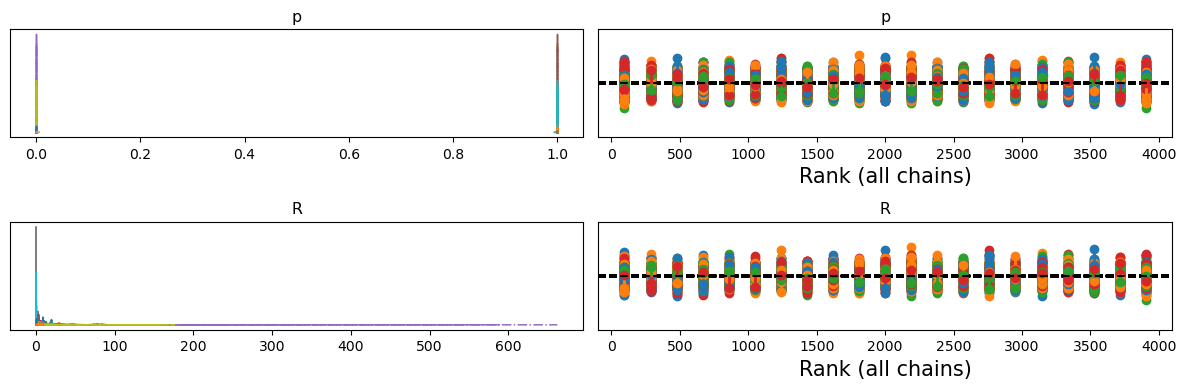

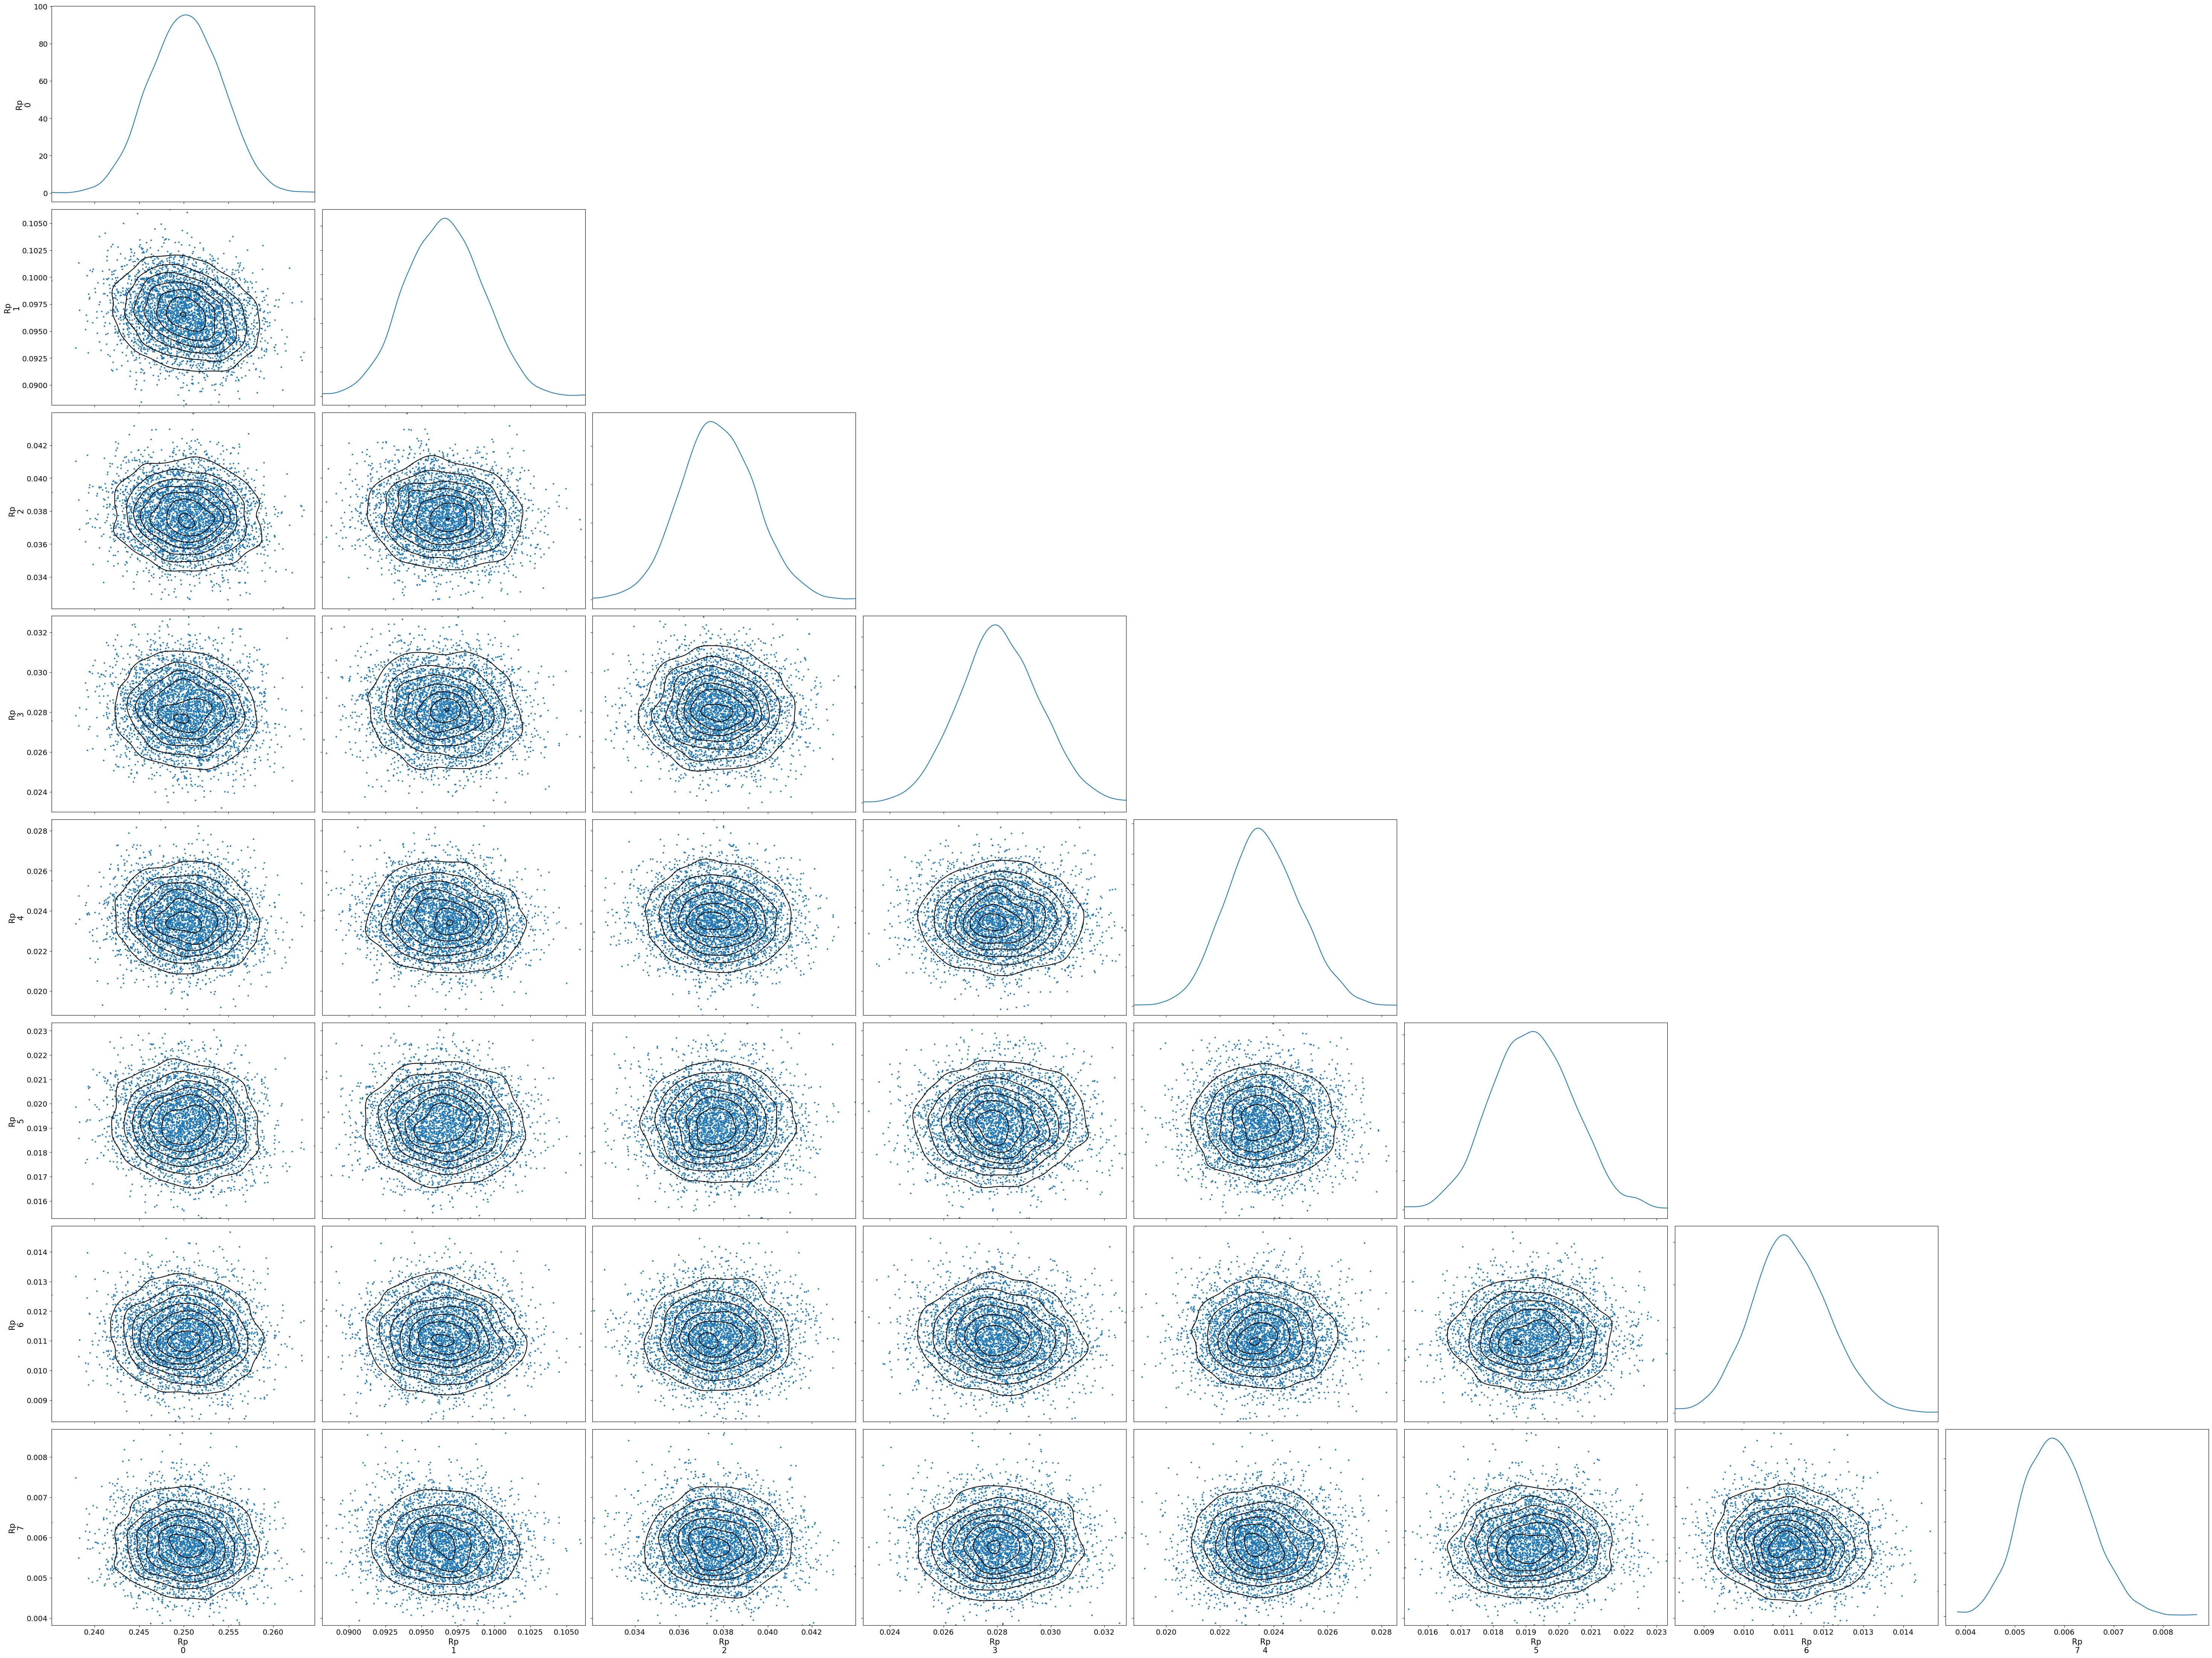

In [7]:
az.plot_trace(idata.posterior, var_names=["p", "R"], kind="rank_vlines")
plt.tight_layout()
plt.savefig("rank_plots.png", dpi=300)
plt.show()
plt.close()

az.plot_pair(idata.posterior, var_names=["Ri"], kind=["scatter", "kde"], marginals=True)
plt.tight_layout()
plt.savefig("pair_plots_Ri.png", dpi=300)
plt.close()

az.plot_pair(idata.posterior, var_names=["Rp"], kind=["scatter", "kde"], marginals=True)
plt.tight_layout()
plt.savefig("pair_plots_Rp.png", dpi=300)
plt.show()
plt.close()


C:\Users\dts-cf924702\AppData\Local\Temp\ipykernel_15768\3212086556.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [mpl.cm.get_cmap('autumn')(x/24) for x in range(24)][:18]


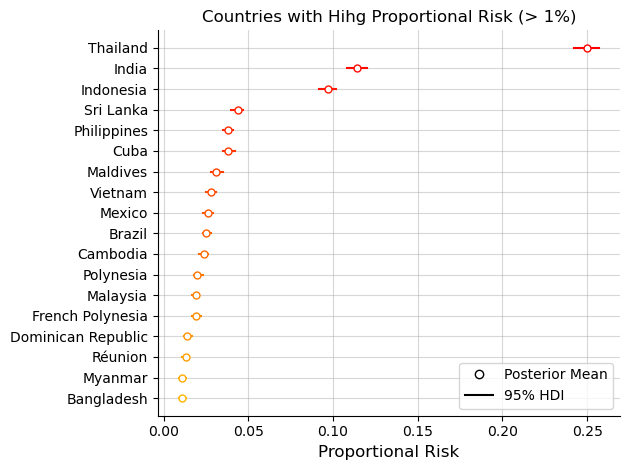

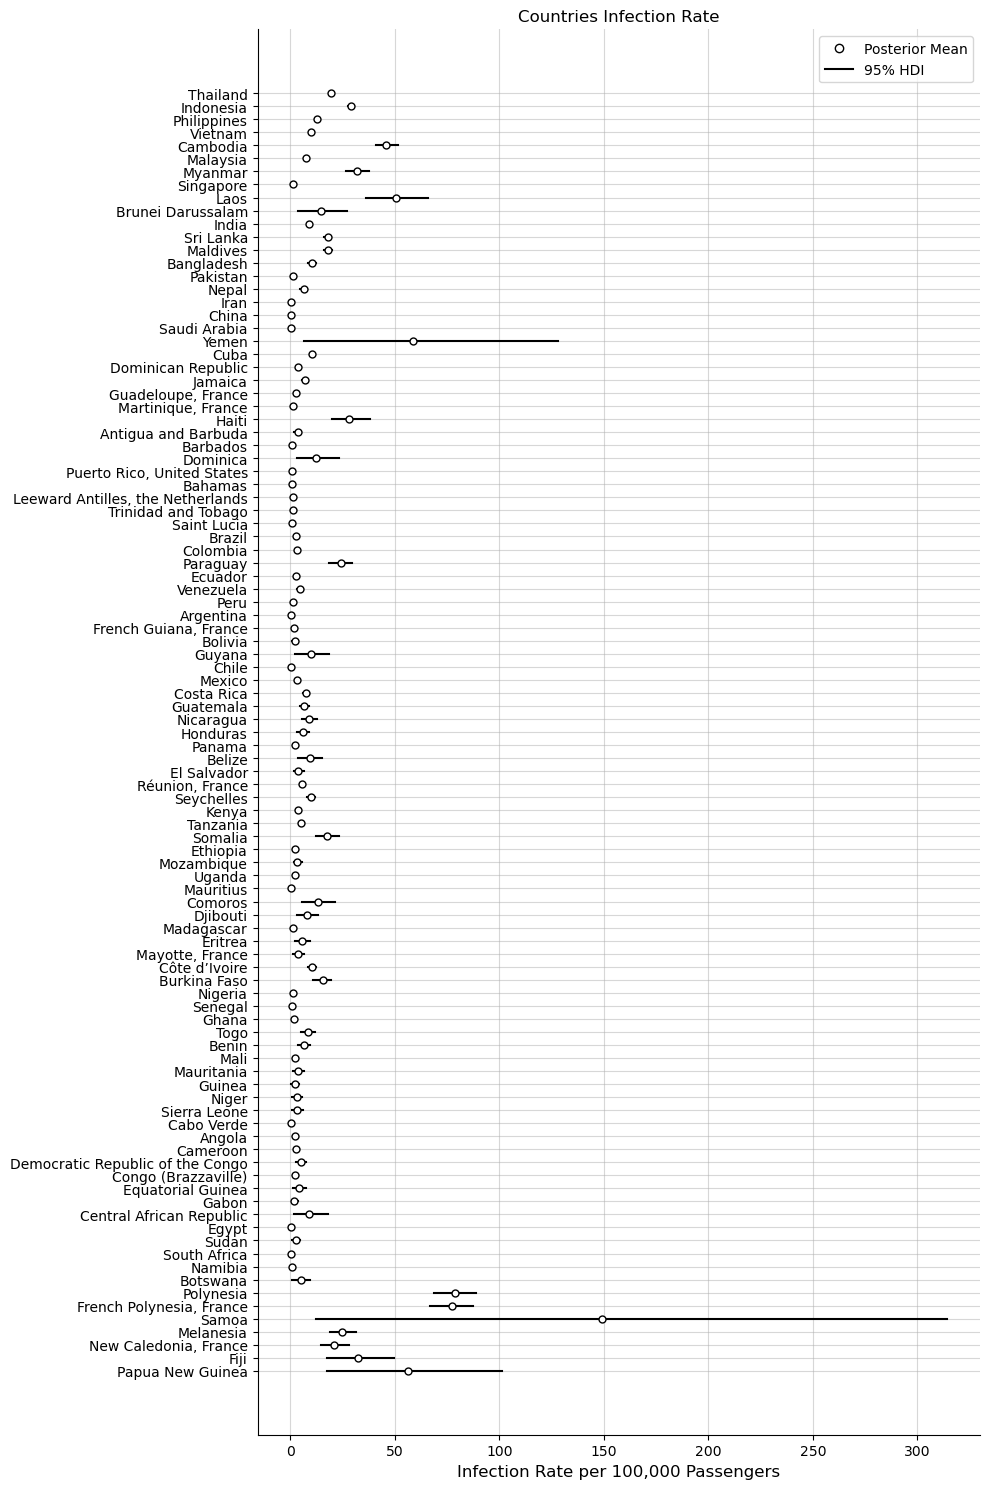

In [8]:
rph = summ[summ.index.str.contains("Rp")]
rph = rph[rph["mean"] > 0.01] #only countries with over 1% risk
rph = rph.sort_values("mean", ascending=False)
names = [rph.country[c].split(",")[0] for c in range(len(rph))]

colors = [mpl.cm.get_cmap('autumn')(x/24) for x in range(24)][:18]
fig, ax = plt.subplots()
for i in range(len(rph)):
    ax.plot((rph["hdi_2.5%"][i], rph["hdi_97.5%"][i]), (17-i, 17-i), color=colors[i])
    ax.plot(rph["mean"][i], 17-i, marker="o", markersize=5, markerfacecolor="w", color=colors[i])
    ax.set_yticks(list(np.flip(np.arange(18))), names)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Proportional Risk", size=12)
    ax.grid(alpha=0.5)
    ax.set_title("Countries with Hihg Proportional Risk (> 1%)")
line = mpl.lines.Line2D([], [], color='k', label='95% HDI')
circle = mpl.lines.Line2D([], [], color='w', marker='o', markeredgecolor='k', label='Posterior Mean')
ax.legend(handles=[circle, line], loc="lower right")
plt.tight_layout()    
plt.savefig("proportional_risk.png", dpi=300)
plt.show()
plt.close()


rs = ["R["+str(i)+"]" for i in range(99)]
rinf = summ[summ.index.isin(rs)]
fig, ax = plt.subplots(figsize=(10,15))
for i in range(len(rinf)):
    ax.plot((rinf["hdi_2.5%"][i], rinf["hdi_97.5%"][i]), (98-i, 98-i), color="k")
    ax.plot(rinf["mean"][i], 98-i, marker="o", markersize=5, markerfacecolor="w", color="k")
    ax.set_yticks(list(np.flip(np.arange(99))), rinf.country.values)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel("Infection Rate per 100,000 Passengers", size=12)
    ax.grid(alpha=0.5)
    ax.set_title("Countries Infection Rate")
line = mpl.lines.Line2D([], [], color='k', label='95% HDI')
circle = mpl.lines.Line2D([], [], color='w', marker='o', markeredgecolor='k', label='Posterior Mean')
ax.legend(handles=[circle, line])
plt.tight_layout()    
plt.savefig("infection_rate.png", dpi=300)
plt.show()
plt.close()

In [9]:

###
#drawbacks: lack of timeline, so cannot tell exposed from not exposed and time-periods
###

'''
References

Gossner CM, Fournet N, Frank C, Fernández-Martínez B, Del Manso M, Gomes Dias J, 
de Valk H. Dengue virus infections among European travellers, 2015 to 2019. 
Euro Surveill. 2022 Jan;27(2):2001937. doi: 10.2807/1560-7917

Lee H, Kim Y, Kim E, ‍Lee S, Risk Assessment of Importation and Local Transmission 
of COVID-19 in South Korea: Statistical Modeling Approach JMIR Public Health 
Surveill 2021;7(6):e26784, doi: 10.2196/26784

'''

'\nReferences\n\nGossner CM, Fournet N, Frank C, Fernández-Martínez B, Del Manso M, Gomes Dias J, \nde Valk H. Dengue virus infections among European travellers, 2015 to 2019. \nEuro Surveill. 2022 Jan;27(2):2001937. doi: 10.2807/1560-7917\n\nLee H, Kim Y, Kim E, \u200dLee S, Risk Assessment of Importation and Local Transmission \nof COVID-19 in South Korea: Statistical Modeling Approach JMIR Public Health \nSurveill 2021;7(6):e26784, doi: 10.2196/26784\n\n'